# Variational Autoencoders (VAE)

The Animal Faces-HQ (AFHQ), consists of 16,130 high-quality images at 512x512 resolution.

There are three domains of classes, each providing about 5000 images. By having multiple (three) domains and diverse images of various breeds per each domain. The classes are:

- Cat
- Dog
- Wildlife
<img src="./figures/inbox_793761_afb6d1aa3be4c82e17a0d0b802436e82_afhq_dataset.jpg" widht="600px">

## 0. Libraries

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1) # to make sure the result always the same
torch.use_deterministic_algorithms(True) # Needed for reproducible results
device = ""
if torch.cuda.is_available():
    print("has gpu, using gpu")
    device = torch.device("cuda")
else:
    print("only cpu, using cpu")
    device = torch.device("cpu")

only cpu, using cpu


## 1. Load Data

- The following code loads the AFHQ data.
- Note that we don't need any validation set, since we are in an unsupervised setting.

In [3]:
image_size = 64 # the images will be resized, and normalized from 0 to 255 => -1 to 1
noc = 3
transform = transforms.Compose(
    [transforms.Resize((image_size,image_size)), transforms.ToTensor()]#, transforms.Normalize((0,0,0,), (1.0/255,1.0/255,1.0/255,))]
)
#transform_denormalize = transforms.Compose(
#    [transforms.Normalize((0,0,0), (1/0.5,1/0.5,1/0.5,)),transforms.Normalize((-0.5,-0.5,-0.5,), (1,1,1))]
#)

In [4]:
train_set = datasets.ImageFolder(root="./data/afhq/train",transform=transform)
len(train_set)

14630

In [5]:
train_set[26][0].shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, '0')

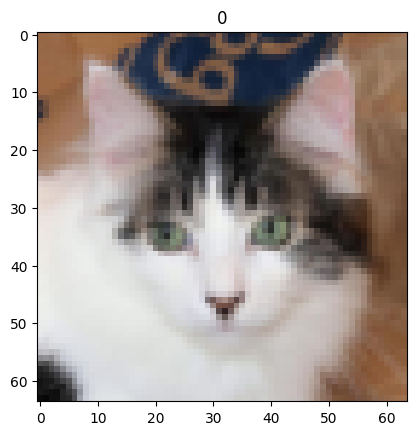

In [6]:
plt.imshow(train_set[26][0].squeeze().permute(1,2,0))
plt.title(train_set[26][1])

In [7]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2)

In [8]:
# data format
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [9]:
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

## 2. VAE with latent space of dim 2

We implement the **variational automnecoder (VAE)** with a latent space of dimensions 2, and show that the *latent space distribution* and the *generative capabilities* of the model are improved.

### Model

The following class implements a **variational autoencoder (VAE)** composed of **linear layers**.

- Understand the architecture and the loss function of this **variational autonecoder (VAE)**.

In [10]:
# model
# class VariationalAutoencoder(nn.Module):
#     """Implements an linear automencoder"""

#     def __init__(self, latent_dim=2):
#         """constructor"""

#         super().__init__()
        
#         self.latent_dim = latent_dim
        
#         self.encoder = nn.Sequential(
#             nn.Linear(image_size * image_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             #nn.ReLU(),                # removed...
#             #nn.Linear(32, latent_dim)
#         )
        
#         self.z_mean = torch.nn.Linear(32, self.latent_dim)
#         self.z_log_var = torch.nn.Linear(32, self.latent_dim)
        
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, image_size * 512),
#             nn.Sigmoid()             # output neurons between 0 and 1
#         )

#     def sampling(self, mean, log_var):
#         "sampling from the latent space"

#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         z = eps.mul(std).add_(mean)

#         return z
    
    
#     def forward(self, x):
#         """forward pass"""
        
#         x = self.encoder(x)
#         mu, log_sigma2 = self.z_mean(x), self.z_log_var(x)
#         z = self.sampling(mu, log_sigma2)
#         x = self.decoder(z)

#         return x, mu, log_sigma2

In [11]:
class VariationalAutoencoder_CNN(nn.Module):
    """Implements a CNN autoencoder"""

    def __init__(self, latent_dim=100):
        """constructor"""

        super().__init__()
        
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(noc, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            #nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(image_size*8, 1, kernel_size=4),
            #nn.Sigmoid(),
            )

        self.z_mean = torch.nn.Linear(256*8*8, self.latent_dim)
        self.z_log_var = torch.nn.Linear(256*8*8, self.latent_dim)

        self.decoder_linear = nn.Linear(in_features=latent_dim, out_features=256*8*8)
        
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(image_size*8*8*8, image_size*8, kernel_size=4),
            #nn.ReLU(),
            #nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(),
            #nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(),
            #nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, noc, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
            )

    def sampling(self, mean, log_var):
        "sampling from the latent space"
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mean)
        return z

    def forward(self, x):
         """forward pass"""
         x = self.encoder(x)
         x = x.view(x.size(0), -1)
         mu, log_sigma2 = self.z_mean(x), self.z_log_var(x)
         z = self.sampling(mu, log_sigma2)
         z = F.relu(self.decoder_linear(z))
         z = z.view(z.size(0), 256, 8, 8)
         x = self.decoder(z)
         return x, mu, log_sigma2


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [12]:
# losses not normalized hence 
alpha, beta = 1., 1.

def loss_function(recon_x, x, mu, log_var):
    "MSE/BCE + KL loss"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, noc, 64, 64), reduction='sum')
    MSE = torch.norm( (recon_x - x.view(-1, noc, image_size, image_size)) ) / x.shape[0]
    KLD = -1.0 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return beta*KLD +alpha*BCE #MSE

### Training

- Intanciate a **VAE** and an **optimizer (`torch.optim.Adam`)** with learning rate `lr=1e-3`.

- Implement a **training loop** for this model during $24$ epochs. During training, after each epoch, store the current `epoch`, `inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

In [13]:
# instanciation
modelVAEd2 = VariationalAutoencoder_CNN(latent_dim=256)

optimizer = torch.optim.Adam(modelVAEd2.parameters(), 
                             lr=1e-3) 
                             #,weight_decay=1e-5)

In [14]:
# training
def training_VAE(model,  num_epochs=60):
    """training loop"""

    #num_epochs = 24
    outputs_l = []

    for epoch in range(num_epochs):

        train_loss = []

        for (inputs, _) in train_loader:

            #inputs = inputs.reshape(-1, image_size*image_size) # reshape data image_size*image_size
            
            outputs, mu, log_var = model(inputs)

            loss = loss_function(outputs, inputs, mu, log_var)
                
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = torch.mean(torch.tensor(train_loss)).item()

        print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

        outputs_l.append((epoch, inputs, outputs, train_loss))
        
    return outputs_l

In [15]:
outputs_l = training_VAE(modelVAEd2)

Epoch:1 	 Train loss: 504689.4062
Epoch:2 	 Train loss: 487224.5625
Epoch:3 	 Train loss: 483923.4375
Epoch:4 	 Train loss: 481958.9375
Epoch:5 	 Train loss: 479463.5312
Epoch:6 	 Train loss: 477391.7500
Epoch:7 	 Train loss: 476012.7188
Epoch:8 	 Train loss: 474865.3125
Epoch:9 	 Train loss: 474094.5938
Epoch:10 	 Train loss: 473475.7812
Epoch:11 	 Train loss: 473066.1562
Epoch:12 	 Train loss: 472768.6875
Epoch:13 	 Train loss: 472386.2812
Epoch:14 	 Train loss: 472064.8438
Epoch:15 	 Train loss: 471926.9062
Epoch:16 	 Train loss: 471713.7500
Epoch:17 	 Train loss: 471597.3750
Epoch:18 	 Train loss: 471347.0625
Epoch:19 	 Train loss: 471330.8438
Epoch:20 	 Train loss: 471181.7188
Epoch:21 	 Train loss: 471022.4688
Epoch:22 	 Train loss: 470987.2500
Epoch:23 	 Train loss: 470846.0938
Epoch:24 	 Train loss: 470728.1875
Epoch:25 	 Train loss: 470683.0938
Epoch:26 	 Train loss: 470560.7188
Epoch:27 	 Train loss: 470555.0312
Epoch:28 	 Train loss: 470425.8125
Epoch:29 	 Train loss: 470351

### Results

- Plot the training loss to confirm that the model has been trained (use the function `plot_training_loss`).

- Plot the inputs and their reconstructions by the VAE at epochs $1$, $12$ and $24$. The reconstructions should improve as the epochs increase. (use the function `plot_training_samples`).

In [16]:
def plot_training_loss(outputs_l, y_label = "BCE loss", filename=""):
    "plot the training loss"
    
    plt.figure(figsize=(5, 3))

    epochs = [x[0] for x in outputs_l]
    train_loss = [x[3] for x in outputs_l]

    plt.plot(epochs, train_loss, label="training loss")
    plt.xlabel("epochs")
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(filename, format="pdf", bbox_inches="tight")
    #plt.show()

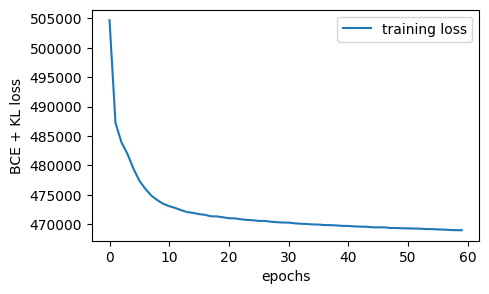

In [17]:
plot_training_loss(outputs_l, y_label="BCE + KL loss", filename="figures/VAE_linear_d2_loss_101_BCEKL.pdf")

In [18]:
def plot_training_samples(outputs_l, filename="", num_epochs=60):
    "plot inputs and reconstructed inputs during training"

    fig, axs = plt.subplots(6, 10, 
                            figsize=(10, 7), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

        inputs = outputs_l[k][1].detach()#.numpy()
        outputs = outputs_l[k][2].detach()#.numpy()

        axs[2*i, 0].set_title(f"Epoch {k+1}")
        axs[2*i, 0].set_ylabel("Inputs")

        for j, item in enumerate(inputs):

            if j >= 10: break
            #item = item.reshape(-1,noc, image_size,image_size) # for Autoencoder_Linear
            axs[2*i, j].imshow(item.squeeze().permute(1,2,0))
            axs[2*i, j].set_xticks([])
            axs[2*i, j].set_yticks([])

        axs[2*i + 1, 0].set_ylabel("Outputs")
        for j, item in enumerate(outputs):
            
            if j >= 10: break
            #item = item.reshape(-1,noc, image_size,image_size) # for Autoencoder_Linear
            axs[2*i + 1, j].imshow(item.squeeze().permute(1,2,0))
            axs[2*i + 1, j].set_xticks([])
            axs[2*i + 1, j].set_yticks([])

    fig.savefig(filename, format="pdf", bbox_inches="tight")
    #plt.show()

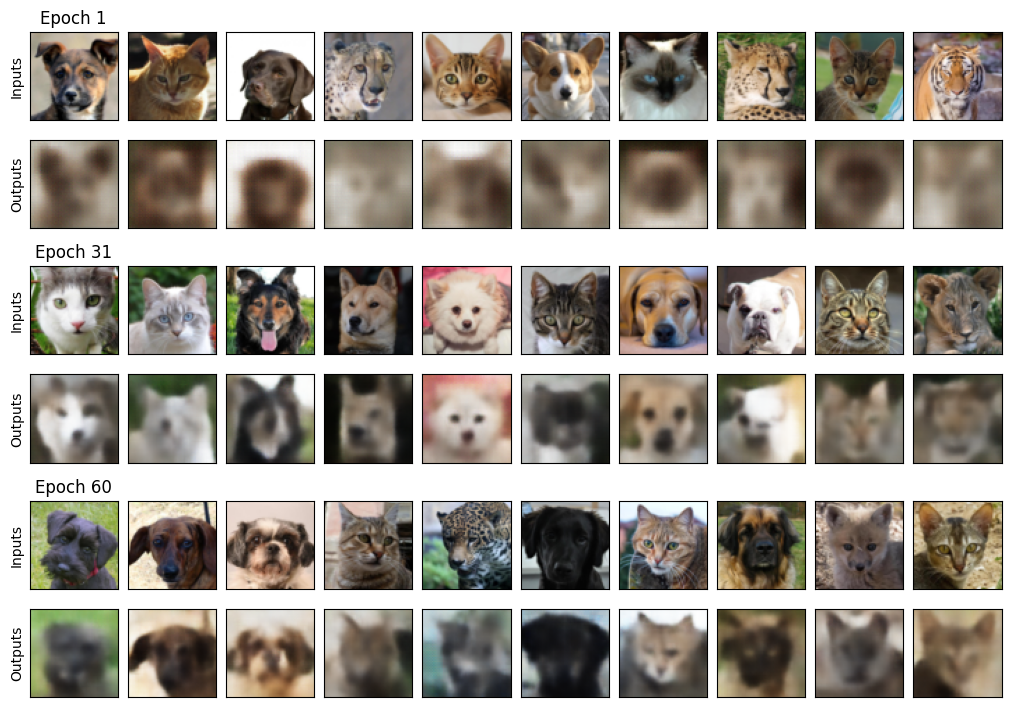

In [19]:
plot_training_samples(outputs_l, filename="figures/VAE_linear_d2_101_BCEKL.pdf")

### Visualizing the latent space

- Run the following code do which plots 1024 encoded images in the **2D latent space**.

- Note that the latent space is **normally distributed** and that the samples of different classes are **clusterized** in this space.

In [20]:
def visualize_2d_latent_space(model, filename):
    
    model.eval()
    #encoder = model.encoder.eval()

    nb_batches = 16
    data_d = {"images" : [], "labels" : []}

    for i, batch in enumerate(train_loader):

        with torch.no_grad():

            images, labels = batch[0], batch[1]
            images = images.reshape(-1, noc, image_size, image_size)
            
            # encode inputs and sample in the latent space
            x, mu, log_sigma2 = model(images)
            #x = encoder(images)
            #mu, log_sigma2 = model.z_mean(x), model.z_log_var(x)
            latent_points = model.sampling(mu, log_sigma2)

            if i == nb_batches:
                break
            else:
                data_d["images"].extend(latent_points)
                data_d["labels"].extend(labels)
    
    nb_images = len(data_d["images"])
    nb_labels = len(data_d["labels"])

    print(f"Nb of encoded images: {nb_images}")
    print(f"Nb of labels: {nb_labels}")

    latent_images = torch.cat(data_d["images"], axis=0).reshape(-1, 2)
    labels = torch.tensor(data_d["labels"])

    x = latent_images[:, 0]
    y = latent_images[:, 1]
    
    print(x.shape, y.shape)
    
    plt.figure(figsize=(10, 7))
    plt.title("Latent space", size=14)

    cm = plt.colormaps.get_cmap('rainbow')

    plt.scatter(x, y, c=labels, alpha=0.6, cmap=cm)

    cbar = plt.colorbar()
    #cbar.set_ticks(np.linspace(0.4, 8.6, 3))
    #cbar.set_ticklabels(list(range(0, 3)))

    plt.savefig(filename, format="pdf", bbox_inches="tight")
    # plt.show()

Nb of encoded images: 1024
Nb of labels: 1024
torch.Size([262144]) torch.Size([262144])


ValueError: 'c' argument has 1024 elements, which is inconsistent with 'x' and 'y' with size 262144.

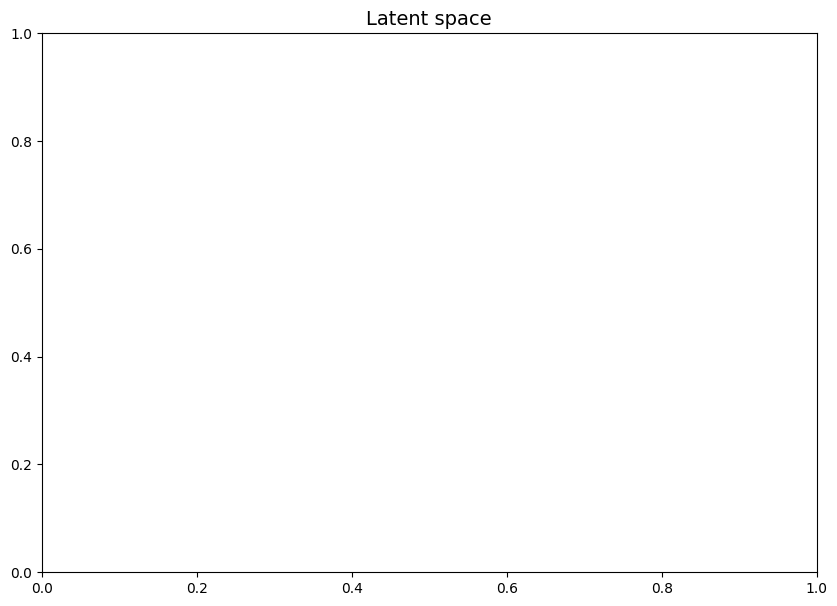

In [21]:
visualize_2d_latent_space(modelVAEd2, "figures/VAE_linear_d2_latent_space_101_MSEKL.pdf")

We implement the **variational automnecoder (VAE)** with a latent space of dimensions 2, and show that the *latent space distribution* and the *generative capabilities* of the model are improved.

## 4. VAE with latent space of dim 20

- Consider now a **variational auttoencoder (VAE)** with latent space of dim 20 (in the instanciation of your object `VariationalAutoencoder`, set `latent_dim=20`).

- Instanciate, train, visualize the inputs/outputs as the training epochs increase, and generate images according to this VAE (you can reuse you previous code on your new VAE).

- How are the generative capabilities of the VAE?

### Model

In [ ]:
modelVAEd20 = VariationalAutoencoder_CNN(latent_dim=20)

# losses not normalized hence 
alpha, beta = 1, 1

def loss_function(recon_x, x, mu, log_var):
    "MSE/BCE + KL loss"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, noc, image_size, image_size), reduction='sum')
    MSE = torch.norm( (recon_x - x.view(-1, noc, image_size, image_size)) ) / x.shape[0]
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return beta*KLD +alpha*BCE #MSE

### Training

In [ ]:
optimizer = torch.optim.Adam(modelVAEd20.parameters(), 
                             lr=1e-3)
                             #, weight_decay=1e-5)

In [ ]:
outputs_l = training_VAE(modelVAEd20,  num_epochs=30)

In [ ]:
plot_training_loss(outputs_l, y_label="BCE + KL loss", filename="figures/VAE_linear_d20_loss.pdf")

In [ ]:
plot_training_samples(outputs_l, filename="figures/VAE_linear_d20_BCEKL.pdf", num_epochs=6)

### Latent space distribution NE MARCHE PAS

In [ ]:
# Plot the distribution, dim by dim, of the latent samples
def plot_latent_distribution(model, filename=""):
    "Generated 1024 points in the latent space and plot their distribution, dim by dim."

    # Create 1024 latent points
    latent_points_l = []

    with torch.no_grad():
        
        for batch, _ in train_loader:
            
            batch = batch.reshape(-1, noc, image_size, image_size)
            
            x, mu, log_sigma2 = model(batch)
            latent_points = model.sampling(mu, log_sigma2)
            latent_points_l.append(model.encoder(batch)[1])
            
            if len(latent_points_l) > 1000//64: break

    latent_points = torch.cat(latent_points_l)
    
    # plotting
    fig, axs = plt.subplots(2, 5, 
                            figsize=(10, 4), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i in range(5):

            samples_1 = np.array(latent_points[:, i])
            samples_2 = np.array(latent_points[:, i+5])
            axs[0, i].hist(samples_1, density=True, bins=15)
            axs[0, i].set_title(f"dim {i+1}")
            axs[1, i].hist(samples_2, density=True, bins=15)
            axs[1, i].set_title(f"dim {i+5+1}")

    fig.savefig(filename, format="pdf", bbox_inches="tight")
    # plt.show()

IndexError: index 8 is out of bounds for dimension 1 with size 8

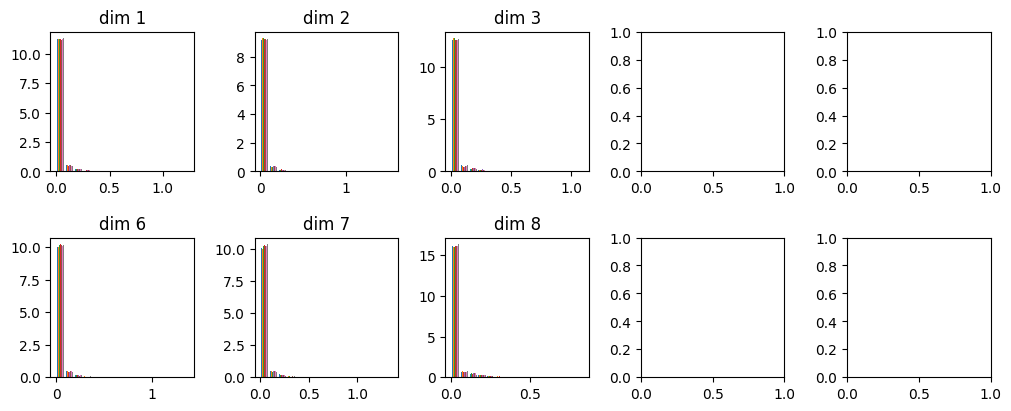

In [ ]:
plot_latent_distribution(modelVAEd20, filename="figures/VAE_linear_d20_latent_space_MSEKL.pdf")

## Generative capabilities of the decoder

In [ ]:
modelVAEd20.eval()

In [ ]:
encoder = modelVAEd20.encoder.eval()
decoder = modelVAEd20.decoder.eval()
decoder

In [ ]:
# Data generation: normal sampling from the latent space + decoding
d = 20
samples_normal = np.random.multivariate_normal(mean=torch.zeros(d),
                                               cov=torch.eye(d),
                                               size=100)
samples_normal = torch.tensor(samples_normal).float()
# Decode samples
with torch.no_grad():
    samples_normal = F.relu(modelVAEd20.decoder_linear(samples_normal))
    samples_normal = samples_normal.view(samples_normal.size(0), 256, 8, 8)
    generated_samples = modelVAEd20.decoder(samples_normal)#.reshape(-1, noc, image_size, image_size)

generated_samples.shape

In [ ]:
def plot_generated_samples(generated_samples, filename=""):
    "plot generated samples"
    
    fig, axs = plt.subplots(10, 10, 
                            figsize=(10, 10), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i in range(10):

        samples = generated_samples[10*i:10*i+10, :, :]

        for j in range(10):

            axs[i, j].imshow(samples[j, :, :].squeeze().permute(1,2,0))
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])


    fig.savefig(filename, format="pdf", bbox_inches="tight")

In [ ]:
plot_generated_samples(generated_samples, filename="figures/VAE_generator_d20_BCEKL.pdf")

**Conclusion**

For a latent space of dimension 20, the latent space is rather normally distributed and the generation capabilities of the model are increased.

# References
## Dataset : 
StarGAN v2: Diverse Image Synthesis for Multiple Domains, Yunjey Choi and Youngjung Uh and Jaejun Yoo and Jung-Woo Ha, Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 2020
## Inspiration :
- TP 13_VariationalAutoencoder
- https://www.kaggle.com/code/jclohjc/animal-image-generator-dcgan

